# DL Assignment 2

Ishaan Reddy
SCDS
210200019

In [1]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image

2.10.1


In [2]:
# load numpy array from npy file
from numpy import load

X_train_std = load('/content/drive/MyDrive/DL_Models/X_train_std.npy')
X_test_std = load('/content/drive/MyDrive/DL_Models/X_test_std.npy')

y_train = load('/content/drive/MyDrive/DL_Models/y_train.npy')
y_test = load('/content/drive/MyDrive/DL_Models/y_test.npy')


In [3]:
print("X_train_std_shape: {}".format(X_train_std.shape))
print("X_test_std_shape: {}".format(X_test_std.shape))

X_train_std_shape: (389, 299, 299, 3)
X_test_std_shape: (130, 299, 299, 3)


In [4]:
# Load the saved best model

model_FineTune = keras.models.load_model('/content/drive/MyDrive/DL_Models/02_Xception_TransferLearning_Best_Model.h5')

In [5]:
model_FT2 = model_FineTune

In [6]:
model_FT2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 305, 305, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 150, 150, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Fine-Tuning

### Model 2: DesnseNet121

In [12]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

freeze_index = len(model_FT2.layers) * 35 // 100


for layer in model_FT2.layers[:freeze_index]:
    layer.trainable = False


for layer in model_FT2.layers[freeze_index:]:
    layer.trainable = True


outputs = Dense(7, activation='softmax')(model_FT2.output)  


model_FT2 = Model(inputs=model_FT2.input, outputs=outputs)

In [13]:
model_FT2.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

callbacks_FT2 = [
             keras.callbacks.ModelCheckpoint("bestFT2.h5",
                                             monitor='val_accuracy',
                                             save_weights_only=True,
                                             save_best_only=True)
]

history_FT2 = model_FT2.fit(x = X_train_std, y = y_train, epochs=10,
                                      validation_split=0.1, batch_size=16, callbacks=callbacks_FT2)

Epoch 1/10
22/22 [==============================] - 117s 4s/step - loss: 1.7795 - accuracy: 0.3171 - val_loss: 1.9358 - val_accuracy: 0.2051
Epoch 2/10
22/22 [==============================] - 89s 4s/step - loss: 1.6709 - accuracy: 0.4229 - val_loss: 1.8782 - val_accuracy: 0.2051
Epoch 3/10
22/22 [==============================] - 90s 4s/step - loss: 1.6511 - accuracy: 0.4200 - val_loss: 1.7861 - val_accuracy: 0.2308
Epoch 4/10
22/22 [==============================] - 89s 4s/step - loss: 1.6108 - accuracy: 0.4886 - val_loss: 1.9143 - val_accuracy: 0.1795
Epoch 5/10
22/22 [==============================] - 91s 4s/step - loss: 1.6028 - accuracy: 0.4743 - val_loss: 1.8366 - val_accuracy: 0.2564
Epoch 6/10
22/22 [==============================] - 94s 4s/step - loss: 1.5770 - accuracy: 0.5086 - val_loss: 1.6648 - val_accuracy: 0.5641
Epoch 7/10
22/22 [==============================] - 159s 7s/step - loss: 1.5368 - accuracy: 0.5314 - val_loss: 1.7323 - val_accuracy: 0.4872
Epoch 8/10
22/22 [

### Evaluate the model 

In [14]:
testLoss_FT, testAccuracy_FT = model_FT2.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FT, testAccuracy_FT))

5/5 [==============================] - 31s 6s/step - loss: 1.5269 - accuracy: 0.6000
Test-loss: 1.526853, Test-accuracy: 0.600000


### Update with best weights

In [15]:
model_FT2.load_weights("bestFT2.h5")

testLoss_FT, testAccuracy_FT = model_FT2.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FT, testAccuracy_FT))

5/5 [==============================] - 32s 6s/step - loss: 1.5269 - accuracy: 0.6000
Test-loss: 1.526853, Test-accuracy: 0.600000


### Confusion Matrix 

In [16]:
y_proba = model_FT2.predict(X_test_std)
y_predict = np.argmax(y_proba, axis=-1)
print(y_predict)

5/5 [==============================] - 64s 5s/step
[2 2 4 4 5 1 1 5 5 1 5 5 6 1 5 1 6 4 5 4 4 5 1 6 4 1 6 5 4 4 1 1 6 5 4 6 1
 4 4 6 5 5 1 5 5 5 4 4 5 5 5 4 4 6 5 5 5 6 5 5 6 5 4 4 5 6 5 5 1 1 6 5 5 6
 5 5 5 4 4 6 5 0 2 5 1 5 5 6 5 5 6 2 5 4 6 6 5 4 4 5 5 5 1 6 1 6 5 4 6 1 1
 6 6 5 4 5 5 5 6 6 6 5 5 2 1 6 5 4 5 0]


In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test, y_pred = y_predict)

array([[ 0,  0,  0,  0,  1, 22,  0],
       [ 0, 17,  0,  0,  0,  1,  2],
       [ 1,  1,  5,  0,  1,  1,  1],
       [ 1,  0,  0,  0,  6,  6,  3],
       [ 0,  0,  0,  0, 17,  1,  3],
       [ 0,  1,  0,  0,  0, 21,  0],
       [ 0,  0,  0,  0,  0,  0, 18]], dtype=int64)

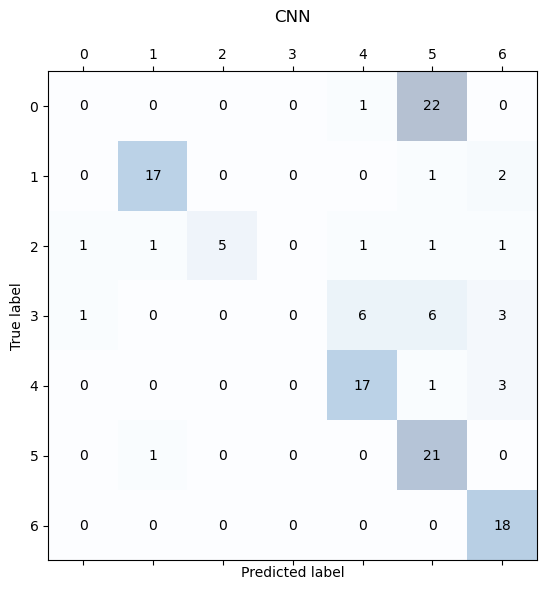

In [18]:
cm = confusion_matrix(y_true = y_test, y_pred = y_predict)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

{0, 1, 2, 3, 4, 5, 6}

['african-wildcat' 'blackfoot-cat' 'chinese-mountain-cat' 'domestic-cat'
 'european-wildcat' 'jungle-cat' 'sand-cat']

### Precision, Recall, F1- Score

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

Precision:  0.48507194020554345
Recall:  0.6
F1-score:  0.5116214593806568


C:\Users\ishaa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Saves the best model obtained
model_FT2.save('/content/drive/MyDrive/DL_Models/02_Xception_FineTuned_Best_Model.h5')